### Habitat Suitability

&nbsp;

Habitat suitability model predicts the abundance of a certain species in a particular area. Based on the availability of these environmental elements throughout a landscape, the model determines which environmental factors a species prefers or avoids. The result would be an index of habitat suitability based on these factors. The model in this script is listed below.

$$Number of Animals Captured = \alpha + \beta_1 \times Vegetation Type + \beta_2 \times Prey Presence  + \beta_3 \times Altitude $$

where

$\alpha$,$\beta$ denotes the coefficients of the model

In [1]:
import sklearn.ensemble
import shapely.geometry
import cv2
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pyproj import Proj
os.chdir('C:/Users/tm/Downloads/utas/thesis/chapter1/tasman')

### functions

In [2]:
#coordinates conversion
def convert_easting_northing_to_lat_lon(easting, northing,):
    proj = Proj('+proj=utm +zone=55 +south +ellps=GRS80 +units=m +no_defs')
    lon, lat = proj(easting, northing, inverse=True)
    return lat, lon

In [3]:
#convert asc file to geopandas
def asc2gpd(info,grid):

    #seperate text and int
    info['name']=[i.split(' ')[0] for i in info[0]]
    info['val']=[float(i.split(' ')[-1] )for i in info[0]]

    #convert to int for lower left x,y, nodatavalue and cell size
    xllcorner=info['val'][info['name']=='xllcorner'].item()
    xllcorner=int(xllcorner)
    yllcorner=info['val'][info['name']=='yllcorner'].item()
    yllcorner=int(round(yllcorner))
    cellsize=info['val'][info['name']=='cellsize'].item()
    cellsize=int(cellsize)
    nodataval=info['val'][info['name']=='NODATA_value'].item()
    nodataval=int(nodataval)

    #get coordinates in matrix form
    nrow=range(yllcorner,yllcorner+cellsize*grid.shape[0],cellsize)
    ncol=range(xllcorner,xllcorner+cellsize*grid.shape[1],cellsize)

    #flip y coordinates
    flatarr=[(i,j) for j in nrow for i in ncol]
    y=np.flip(np.array([i[1] for i in flatarr]).reshape(grid.shape),axis=0).flatten().tolist()

    #create geopandas
    export=pd.DataFrame()
    export['coords']=list(zip([i[0] for i in flatarr],y))
    export['altitude']=grid.flatten()
    export['coords'] = export['coords'].apply(shapely.geometry.Point)
    output=gpd.GeoDataFrame(export, geometry='coords')

    #remove nodata point
    output=output[output['altitude']!=nodataval]    
    
    return output

### global variables

In [4]:
lonmax=148.19770312099925;latmax=-42.826341401892726;
lonmin=147.5879619192109;latmin=-43.27791719967915;
lat_centre=-43.03648678978083; lon_centre=147.83240771632424;
gridlen=50

### island map

In [5]:
#create map
#alternative projection could be crs4236 wgs84
carte=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,
              urcrnrlon=lonmax,urcrnrlat=latmax,
              resolution='f', projection='tmerc', 
             lat_0=lat_centre,lon_0=lon_centre,)

carte.drawmapboundary(fill_color='w')
carte.fillcontinents(color='k',lake_color='w')
carte.drawcoastlines()
plt.savefig('./images/base.png',bbox_inches='tight',
                    pad_inches=-.05)
plt.clf()


#down scale image
baselayer=cv2.imread('./images/base.png',0)
baselayer=cv2.resize(baselayer,dsize=(gridlen,gridlen,),
                   interpolation=cv2.INTER_AREA)
        

<Figure size 640x480 with 0 Axes>

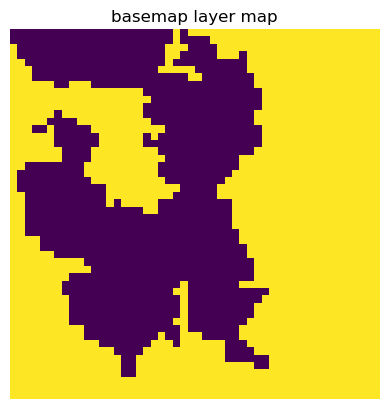

In [6]:
#manual dilution
baselayer[baselayer>=180]=255
baselayer[baselayer<180]=0
plt.imshow(baselayer)
plt.title('basemap layer map')
plt.axis('off')
plt.show()

In [7]:
df_baselayer=pd.DataFrame()
df_baselayer['grid']=baselayer.flatten()
df_baselayer.to_csv('./poems/baselayer.csv',index=False)

### NVA devil

In [8]:
dataset=[]
for i in os.listdir('./Data collation for Forestier Peninsula'):
    if 'xlsx' not in i:
        filename=os.listdir(f'./Data collation for Forestier Peninsula/{i}')[0]
        spreadsheet=pd.ExcelFile(f'./Data collation for Forestier Peninsula/{i}/{filename}')        
        dataset.append(spreadsheet.parse(spreadsheet.sheet_names[0]))

C:\Users\tm\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\tm\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\tm\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\tm\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\tm\Anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default sty

In [9]:
subset=pd.concat([i for i in dataset])

In [10]:
subset['lat'],subset['lon']=convert_easting_northing_to_lat_lon(subset['EASTING'], subset['NORTHING'])

#locate where the devils are on a 20 by 20 raster
lonunit=(lonmax-lonmin)/gridlen
latunit=(latmax-latmin)/gridlen
subset['lat num']=(subset['lat']-latmin)//latunit
subset['lon num']=(subset['lon']-lonmin)//lonunit
subset['coordinates']=list(zip(subset['lat num'].astype(int),subset['lon num'].astype(int)))

#each individual in a given grid cell counts as one
subset=subset.loc[subset[['INDIVIDUAL','coordinates']].drop_duplicates().index]

C:\Users\tm\AppData\Local\Temp\ipykernel_25340\1870988043.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  subset['lat'],subset['lon']=convert_easting_northing_to_lat_lon(subset['EASTING'], subset['NORTHING'])
C:\Users\tm\AppData\Local\Temp\ipykernel_25340\1870988043.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  subset['lat'],subset['lon']=convert_easting_northing_to_lat_lon(subset['EASTING'], subset['NORTHING'])
C:\Users\tm\AppData\Local\Temp\ipykernel_25340\1870988043.py:6: PerformanceWarning: DataFrame is highly frag

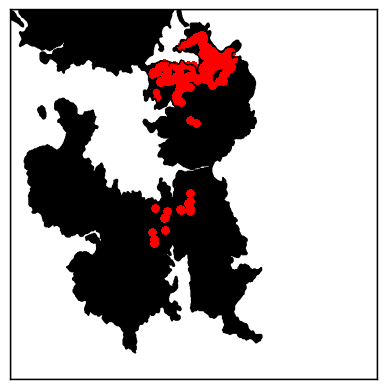

In [11]:
carte=Basemap(llcrnrlon=lonmin,llcrnrlat=latmin,
              urcrnrlon=lonmax,urcrnrlat=latmax,
              resolution='f', projection='tmerc', 
             lat_0=lat_centre,lon_0=lon_centre,)

carte.drawmapboundary(fill_color='w')
carte.fillcontinents(color='k',lake_color='w')

x,y=carte(subset['lon'],subset['lat'],)
plt.scatter(x,y,s=20,c='red')
carte.drawcoastlines()

In [12]:
#create matrix
devilcount=subset.groupby(['coordinates']).count()
devil=np.zeros((gridlen,gridlen))
for i in range(len(devilcount)):
    loc=devilcount.index[i]
    if loc[0]>gridlen or loc[0]<0 or loc[1]>gridlen or loc[1]<0:
        continue
    devil[loc]=devilcount['INDIVIDUAL'].iloc[i]

#flip matrix vertically
devil=np.flip(devil,0)

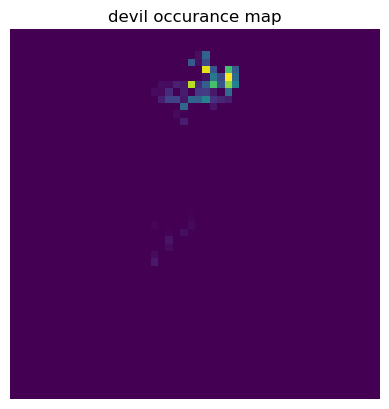

In [13]:
plt.imshow(devil)
plt.title('devil occurance map')
plt.axis('off')
plt.show()

### vegetation

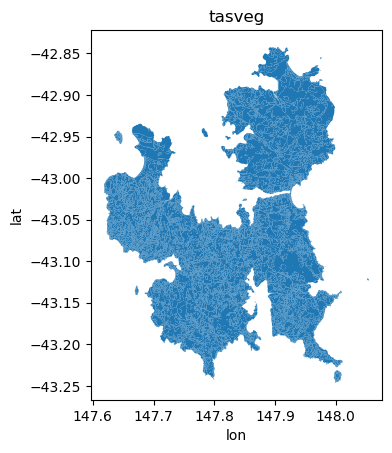

In [14]:
#convert stupid utm to lat lon
zips = gpd.read_file('./LIST_TASVEG_40_TASMAN/list_tasveg_40_tasman.shp')
zips = zips.to_crs('epsg:4326')
#+proj=utm +zone=55 +south +ellps=GRS80 +units=m +no_defs
zips.plot()
plt.title('tasveg')
plt.xlabel('lon')
plt.ylabel('lat')
plt.show()
zips.to_file('./LIST_TASVEG_40_TASMAN/penin.shp', driver='ESRI Shapefile')

In [15]:
#crop to tasman peninsula
subset=zips.cx[lonmin:lonmax,
              latmin:latmax]

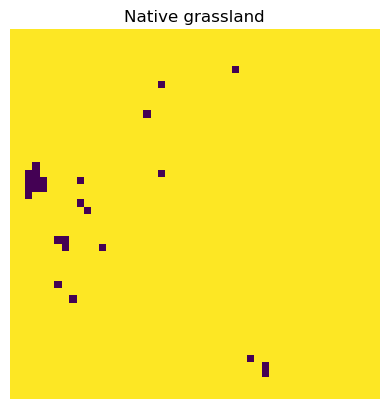

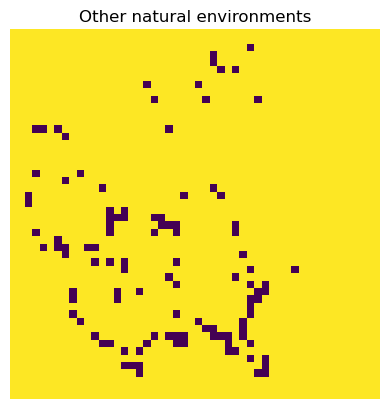

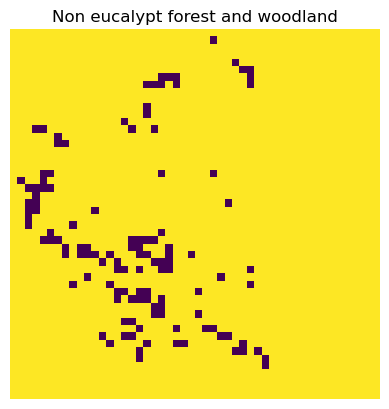

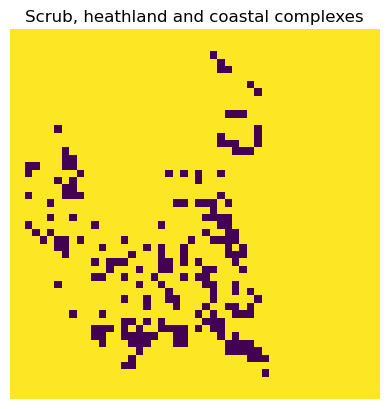

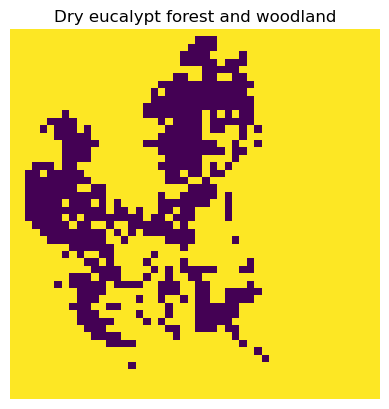

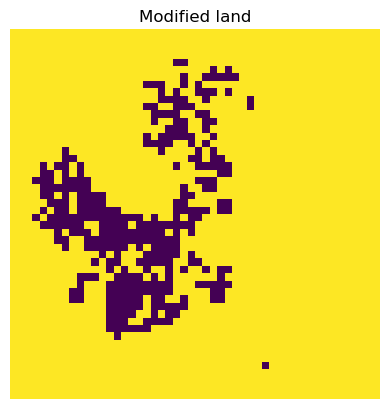

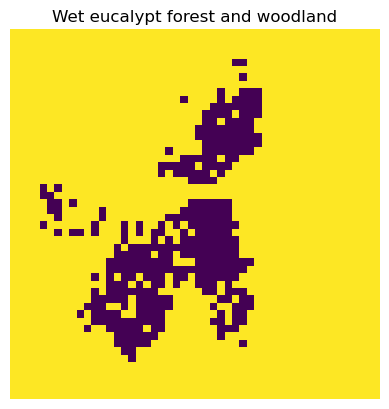

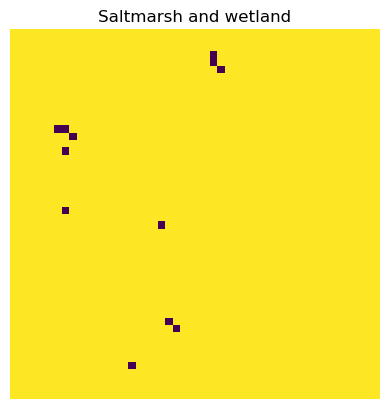

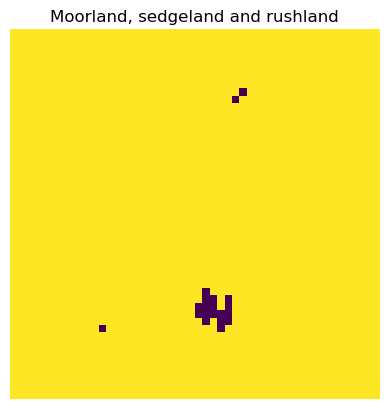

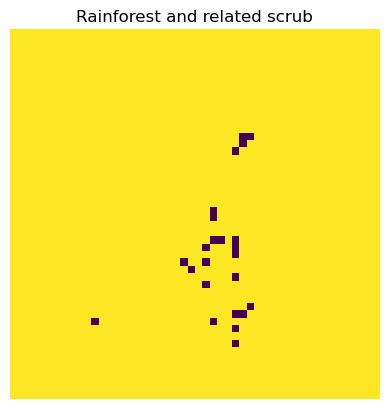

In [16]:
#plot each vegetation type
veg_group={}
for i in subset["VEG_GROUP"].unique():
    subsub=subset[subset["VEG_GROUP"]==i]
    ax=subsub.plot(column="VEG_GROUP")
    ax.set_xlim((lonmin,lonmax))
    ax.set_ylim((latmin,latmax))
    ax.axis('off')    
    plt.savefig(f'./images/{i}.png',bbox_inches='tight',
                    pad_inches=-.05)
    plt.clf()    
    plt.clf()

    #down scale image
    vegtype=cv2.imread(f'./images/{i}.png',0)
    vegtype=cv2.resize(vegtype,dsize=(gridlen,gridlen),
                       interpolation=cv2.INTER_LANCZOS4)
    vegtype[vegtype<255]=0
    veg_group[i]=vegtype
    plt.imshow(veg_group[i])
    plt.title(i)
    plt.axis('off')
    plt.show()

### elevation

In [17]:
#read asc file into matrix
grid=np.loadtxt("./LIST_DEM_25M_TASMAN/list_dem_25m_tasman.asc", skiprows=6)

#read the header of asc file to map the coordinates
info=pd.read_csv("./LIST_DEM_25M_TASMAN/list_dem_25m_tasman.asc",header=None, nrows=6)

In [18]:
#convert coordinates
output=asc2gpd(info,grid)

zips = gpd.read_file('./LIST_DEM_25M_TASMAN/municipality_tasman.shp')
output=output.set_crs(zips.crs)
output=output.to_crs('epsg:4326')

subset=output.cx[lonmin:lonmax,
              latmin:latmax]

In [19]:
#convert matrix to raster
subset['lon']=subset['coords'].apply(lambda x:x.xy[0][0])
subset['lat']=subset['coords'].apply(lambda x:x.xy[1][0])
lonunit=(lonmax-lonmin)/gridlen
latunit=(latmax-latmin)/gridlen
subset['lat num']=(subset['lat']-latmin)//latunit
subset['lon num']=(subset['lon']-lonmin)//lonunit
subset['id']=list(zip(subset['lat num'].astype(int),subset['lon num'].astype(int)))

In [20]:
#compute mean altitude by each cell
height=subset[['id','altitude']].groupby('id').mean()['altitude']

In [21]:
#generate raster
altitude=np.zeros(devil.shape)
for i in range(len(height)):
    altitude[height.index[i]]=height.iloc[i]
altitude=np.flip(altitude,axis=0)

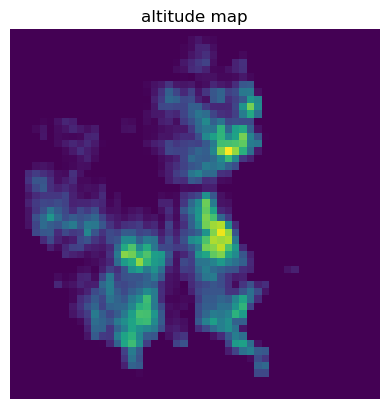

In [22]:
#viz
plt.imshow(altitude)
plt.title('altitude map')
plt.axis('off')
plt.show()

### matrix form

In [23]:
#generate data
data=pd.DataFrame()
data['devil']=devil.flatten()

#create habitat suitability index
data['index']=data['devil']
arr=altitude.flatten()
data['altitude']=arr

In [24]:
#convert array to binary
arr=baselayer.flatten()
arr[arr==0]=1
arr[arr==255]=0
data['base']=arr

for i in veg_group:
    arr=veg_group[i].flatten()
    arr[arr==0]=1
    arr[arr==255]=0
    data[i]=arr

In [26]:
#captures the penninsula and exclude extra land area
filtered_nontasman=data[['Native grassland',
       'Other natural environments', 'Non eucalypt forest and woodland',
       'Scrub, heathland and coastal complexes',
       'Dry eucalypt forest and woodland', 'Modified land',
       'Wet eucalypt forest and woodland', 'Saltmarsh and wetland',
       'Moorland, sedgeland and rushland', 'Rainforest and related scrub']].T

actual_tasman_ind=[]
for i in filtered_nontasman:
    if not (filtered_nontasman[i]==0).all():
        actual_tasman_ind.append(i)

### random forest

In [ ]:
data['base'].loc[list(set(data[data['base']==1].index).difference(set(actual_tasman_ind)))]=0

In [ ]:
data['index'][data['base']==0]=0

In [ ]:
#remove sea area
land=data[data['base']==1]

#only work on the cells with recorded devil capture
training=land[land['index']!=0]

In [ ]:
#train and predict
clf=sklearn.ensemble.RandomForestRegressor()

clf.fit(training[['altitude', 'base', 'Native grassland',
       'Other natural environments', 'Non eucalypt forest and woodland',
       'Scrub, heathland and coastal complexes',
       'Dry eucalypt forest and woodland', 'Modified land',
       'Wet eucalypt forest and woodland', 'Saltmarsh and wetland',
       'Moorland, sedgeland and rushland', 'Rainforest and related scrub']],training['index'])

land['pred']=clf.predict(land[['altitude', 'base', 'Native grassland',
       'Other natural environments', 'Non eucalypt forest and woodland',
       'Scrub, heathland and coastal complexes',
       'Dry eucalypt forest and woodland', 'Modified land',
       'Wet eucalypt forest and woodland', 'Saltmarsh and wetland',
       'Moorland, sedgeland and rushland', 'Rainforest and related scrub']])

data['pred']=land['pred']

In [ ]:
#not bad for scarce data points
clf.score(training[['altitude', 'base', 'Native grassland',
       'Other natural environments', 'Non eucalypt forest and woodland',
       'Scrub, heathland and coastal complexes',
       'Dry eucalypt forest and woodland', 'Modified land',
       'Wet eucalypt forest and woodland', 'Saltmarsh and wetland',
       'Moorland, sedgeland and rushland', 'Rainforest and related scrub']],training['index'])

In [ ]:
#viz habitat suitability map
plt.imshow(np.array(data['pred']).reshape(gridlen,gridlen),cmap='RdBu_r')
plt.title('habitat suitability map')
plt.axis('off')
plt.show()

In [ ]:
data['pred'].loc[data[data['index']!=0].index]=data['index'][data['index']!=0].tolist()

In [ ]:
data[['pred']].to_csv('./poems/suitability.csv',index=False)

In [ ]:
#create map data
arr=data['base'].to_numpy()
arr[arr==0]=255
arr[arr==1]=0
df_baselayer=pd.DataFrame()
df_baselayer['grid']=arr
df_baselayer.to_csv('./poems/baselayer.csv',index=False)

In [ ]:
#convert lattice to adjacency list
check_matrix=arr.reshape(gridlen,gridlen)
adj_list={}

for i in range(gridlen**2):
    current_tile=[i//gridlen,i%gridlen]
    
    if check_matrix[current_tile[0],current_tile[1]]==0:
        adj_list[i]=[]
        
        up=[current_tile[0]-1,current_tile[1]]
        down=[current_tile[0]+1,current_tile[1]]
        left=[current_tile[0],current_tile[1]-1]
        right=[current_tile[0],current_tile[1]+1]

        
        if up[0]>=0 and check_matrix[current_tile[0]-1,current_tile[1]]==0:
            adj_list[i].append(i-gridlen)

        if down[0]<gridlen and check_matrix[current_tile[0]+1,current_tile[1]]==0:
            adj_list[i].append(i+gridlen)
        
        if left[1]>=0 and check_matrix[current_tile[0],current_tile[1]-1]==0:
            adj_list[i].append(i-1)

        if right[1]<gridlen and check_matrix[current_tile[0],current_tile[1]]+1==0:
            adj_list[i].append(i+1)
            

In [ ]:
#use bfs to identify the grids required for validation within the radius
counter=0
stop=False
lvl={}
lvl[0]=training[training['index']!=0].index.tolist()
radius=12
while not stop:
    
    queue=[]
    counter+=1
    if counter==radius:
        stop=True
    for i in list(lvl.values())[-1]:
        queue+=adj_list[i]
    lvl[counter]=list(set(queue))

validation_target=sorted(list(set([j for i in lvl.values() for j in i])))

In [ ]:
#create validation area file
valid=pd.DataFrame(index=df_baselayer.index)
valid['target']=0
valid['target'].loc[validation_target]=1
valid.to_csv('./poems/validation.csv',index=False)

In [ ]:
#reindex validation area against land area
land['ID']=range(len(land))
identity=pd.DataFrame()
identity['ID']=land['ID'].loc[validation_target].tolist()
identity.to_csv('./poems/identity.csv',index=False)